In [115]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score

In [116]:
data = pd.read_csv('Titanic.csv')

In [117]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [81]:
data = data.drop(['Name','PassengerId'], axis = 1)

In [82]:
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,female,35.0,1,0,113803,53.1000,C123,S
4,0,3,male,35.0,0,0,373450,8.0500,NaN,S


In [83]:
def  missing(data):
    
    missing = pd.DataFrame(data.dtypes,columns = ['Dtypes'])
    missing_vals = data.isna().sum()
    missing['Missing_vals'] = missing_vals
    missing['Missing_percentage'] = missing_vals/missing.shape[0]
    missing['Unique_values'] = data.nunique()
    des = missing.describe().T
    pd.concat([missing,des], axis = 1)
    
    return missing

In [84]:
missing(data)

,Dtypes,Missing_vals,Missing_percentage,Unique_values
Survived,int64,0,0.0,2
Pclass,int64,0,0.0,3
Sex,object,0,0.0,2
Age,float64,177,17.7,88
SibSp,int64,0,0.0,7
Parch,int64,0,0.0,7
Ticket,object,0,0.0,681
Fare,float64,0,0.0,248
Cabin,object,687,68.7,147
Embarked,object,2,0.2,3


In [85]:
data = data.drop(['Cabin','Ticket'], axis = 1)

In [86]:
data['Age'].fillna((data['Age'].mean()), inplace=True)

In [87]:
data = data.dropna()

In [88]:
data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.000000,1,0,7.2500,S
1,1,1,female,38.000000,1,0,71.2833,C
2,1,3,female,26.000000,0,0,7.9250,S
3,1,1,female,35.000000,1,0,53.1000,S
4,0,3,male,35.000000,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.000000,0,0,13.0000,S
887,1,1,female,19.000000,0,0,30.0000,S
888,0,3,female,29.699118,1,2,23.4500,S
889,1,1,male,26.000000,0,0,30.0000,C


In [89]:
nums = data.select_dtypes(include = ['int','float'])
cats = data.select_dtypes(include = ['object'])

In [90]:
le = preprocessing.LabelEncoder()

In [91]:
cats = cats.apply(le.fit_transform)

In [95]:
X = pd.concat([cats,nums], axis =1)
y = X['Survived']
X = X.drop(['Survived'], axis = 1)

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

In [97]:
xgb_model = XGBClassifier(n_estimators=1000, max_depth=10, learning_rate=0.001, random_state=0,enable_categorical=True, verbose = 1)
xgb_model.fit(X_train, y_train)

/Users/thomasrowe/.local/share/virtualenvs/Dev-fNV4jyM8/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:03:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "enable_categorical", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:03:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=True,
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.001, max_delta_step=0,
              max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=16,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbose=1, verbosity=None)

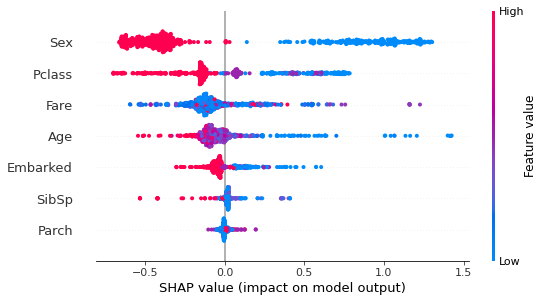

In [100]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns)

In [112]:
kf = StratifiedKFold(n_splits = 5)
RF = RandomForestClassifier()
DC = DecisionTreeClassifier()
LR = LogisticRegression()
models = [RF,DC,LR]

aucs = []
final_aucs = []

for c in models:
    

    for train_index,test_index in kf.split(X,y):
        train_x,test_x= X.iloc[train_index],X.iloc[test_index]
        train_y,test_y= y.iloc[train_index],y.iloc[test_index]
        c.fit(train_x,train_y)
        preds = c.predict_proba(test_x)
        auc = roc_auc_score(test_y, preds[:,1])
        aucs.append(auc)
    avg = np.mean(aucs)
    final_aucs.append(avg)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

In [113]:
final_aucs

[0.8547875680714322, 0.807518152381887, 0.8213687877152529]